In [87]:
from polygon import RESTClient
import mplfinance as mpf
import pandas as pd
import numpy as np
import datetime as dt
import requests
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller


client = RESTClient("2zH7AFDp4wW1Uqov4zGvbpA2aUNHbk__adRrOG")  # POLYGON_API_KEY environment variable is used

# make request
request = client.get_daily_open_close_agg(
    "AAPL",
    "2023-02-07",
)
print(request)

DailyOpenCloseAgg(after_hours=154.15, close=154.65, from_='2023-02-07', high=155.23, low=150.64, open=150.64, pre_market=151.79, status='OK', symbol='AAPL', volume=83322551.0, otc=None)


In [203]:
def get_stock(ticker, multiplier, timespan, start_date, end_date):
    
    # Construct the URL
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{multiplier}/{timespan}/{start_date}/{end_date}"
    params = {
        "apiKey": API_KEY,
        "adjusted": "false" ,
        "limit":50000
    }
    
    # Make the API request
    response = requests.get(url, params=params)
    
    # Check response status
    if response.status_code == 200:
        print("success")
    else:
        print(f"Error: {response.status_code}, {response.text}")

    df = pd.DataFrame(response.json()['results'])
    df['t'] = pd.to_datetime(df['t'], unit='ms')- dt.timedelta(hours=4)

    df.set_index('t', inplace=True)  # Set timestamp as index
    df.rename(columns={'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume','n':'n_trades'}, inplace=True)

    return df

def regular_hour(df):
    """
    index in datetime format
    """
    df['t'] = df.index
    df['time'] = df['t'].dt.time
    threshold_time_start = pd.to_datetime('9:30').time()
    threshold_time_end = pd.to_datetime('16:00').time()
    df = df[(df['time'] >= threshold_time_start) & (df['time'] < threshold_time_end)]

    return df

def returns(df):
    
    df = df.sort_index()
    df['log_ret'] = np.log(df['Close'] / df['Close'].shift(1))
    
    return df

In [205]:
API_KEY = "2zH7AFDp4wW1Uqov4zGvbpA2aUNHbk__adRrOG"
multiplier = 30
timespan = "minute"
start_date = "2024-09-01"
end_date = "2024-11-23"

PDD = get_stock('PDD', multiplier, timespan,start_date,end_date)
BABA = get_stock('BABA', multiplier, timespan,start_date,end_date)

success
success


                            OLS Regression Results                            
Dep. Variable:                log_ret   R-squared:                       0.485
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     719.4
Date:                Sun, 24 Nov 2024   Prob (F-statistic):          3.48e-112
Time:                        00:13:13   Log-Likelihood:                 2689.6
No. Observations:                 766   AIC:                            -5375.
Df Residuals:                     764   BIC:                            -5366.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.147e-05      0.000      0.120      0.9

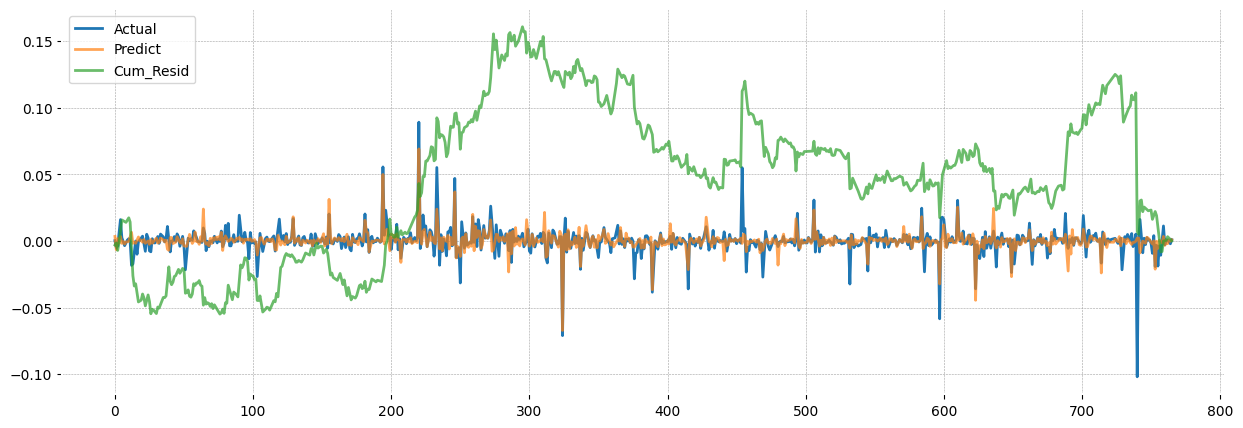

ADF p-value: 0.0
Reject the null hypothesis: The series is stationary.


In [209]:
PDD = returns(regular_hour(PDD))
BABA = returns(regular_hour(BABA))
# Define the independent variables (X) and dependent variable (Y)
X = BABA['log_ret'].iloc[1:]  # Independent variables
Y = PDD['log_ret'].iloc[1:]           # Dependent variable

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)  # This adds a column of 1s for the intercept term

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print the results
print(model.summary())
plt.figure(figsize = (15,5))
plt.plot(Y.values, label = "Actual")
plt.plot(model.predict(),alpha = 0.7, label = 'Predict')
plt.plot(model.resid.cumsum().values, alpha = 0.7, label = 'Cum_Resid')
plt.legend()
plt.show()

adf_result = adfuller(model.resid)
print('ADF p-value:', adf_result[1])
if adf_result[1] < 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")

In [245]:
start_date = "2024-07-01"
end_date = "2024-10-01"

PDD = get_stock('PDD', multiplier, timespan,start_date,end_date)
BABA = get_stock('BABA', multiplier, timespan,start_date,end_date)

success
success


In [247]:
PDD = returns(regular_hour(PDD))
BABA = returns(regular_hour(BABA))
print(len(PDD),len(BABA))

840 840


                            OLS Regression Results                            
Dep. Variable:                log_ret   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.337
Method:                 Least Squares   F-statistic:                     426.7
Date:                Sun, 24 Nov 2024   Prob (F-statistic):           6.35e-77
Time:                        00:17:03   Log-Likelihood:                 2581.8
No. Observations:                 839   AIC:                            -5160.
Df Residuals:                     837   BIC:                            -5150.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.333      0.1

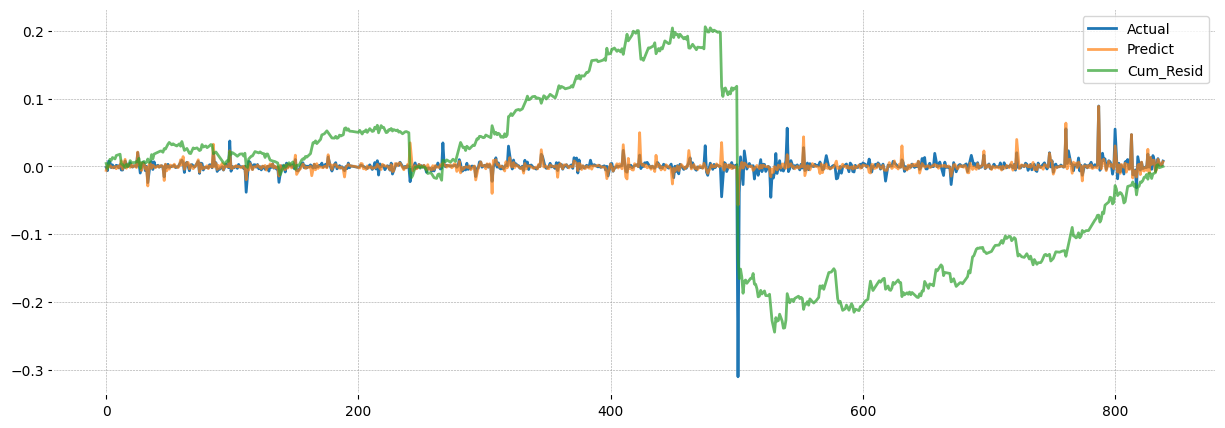

ADF p-value: 1.54925872648263e-08
Reject the null hypothesis: The series is stationary.


In [250]:
# Define the independent variables (X) and dependent variable (Y)
X = BABA['log_ret'].iloc[1:]  # Independent variables
Y = PDD['log_ret'].iloc[1:]           # Dependent variable

# Add a constant (intercept) to the independent variables
X = sm.add_constant(X)  # This adds a column of 1s for the intercept term

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print the results
print(model.summary())
plt.figure(figsize = (15,5))
plt.plot(Y.values, label = "Actual")
plt.plot(model.predict(),alpha = 0.7, label = 'Predict')
plt.plot(model.resid.cumsum().values, alpha = 0.7, label = 'Cum_Resid')
plt.legend()
plt.show()

adf_result = adfuller(model.resid)
print('ADF p-value:', adf_result[1])
if adf_result[1] < 0.05:
    print("Reject the null hypothesis: The series is stationary.")
else:
    print("Fail to reject the null hypothesis: The series is non-stationary.")

In [241]:
X

,const,log_ret
t,,
2024-05-01 10:00:00,1.0,0.006111
2024-05-01 10:30:00,1.0,0.006073
2024-05-01 11:00:00,1.0,-0.001581
2024-05-01 11:30:00,1.0,0.000461
2024-05-01 12:00:00,1.0,0.002040
...,...,...
2024-08-01 13:30:00,1.0,0.001150
2024-08-01 14:00:00,1.0,-0.003646
2024-08-01 14:30:00,1.0,-0.001218


In [243]:
Y

t
2024-05-01 10:00:00    0.011799
2024-05-01 10:30:00    0.001085
2024-05-01 11:00:00   -0.004469
2024-05-01 11:30:00    0.000645
2024-05-01 12:00:00    0.000403
                         ...   
2024-08-01 13:30:00   -0.000273
2024-08-01 14:00:00   -0.003087
2024-08-01 14:30:00    0.000548
2024-08-01 15:00:00    0.000078
2024-08-01 15:30:00   -0.000156
Name: log_ret, Length: 826, dtype: float64